In [1]:
import jax.numpy as np
import numpy as onp
from jax import grad, jit, vmap
from jax import random
import matplotlib.pyplot as plt

import morphine

%matplotlib inline

import matplotlib as mpl
mpl.style.use('seaborn-colorblind')
phasemap = mpl.cm.rainbow
phasemap.set_bad(color='k')


#To make sure we have always the same matplotlib settings
#(the ones in comments are the ipython notebook settings)

mpl.rcParams['figure.figsize']=(12.0,9.0)    #(6.0,4.0)
mpl.rcParams['font.size']=20               #10 
mpl.rcParams['savefig.dpi']= 200             #72 
mpl.rcParams['axes.labelsize'] = 18
mpl.rcParams['axes.labelsize'] = 18
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14
from matplotlib import rc
mpl.rcParams["font.family"] = "Times New Roman"

colours = mpl.rcParams['axes.prop_cycle'].by_key()['color']

from astropy import units as units

shift = np.fft.fftshift
fft   = np.fft.fft2
ifft  = np.fft.ifft2
fftfreq = np.fft.fftfreq

dtor = np.pi/180.0

import warnings
warnings.filterwarnings("ignore")


/Users/benjaminpope/opt/anaconda3/lib/python3.7/site-packages/pysynphot/locations.py:346: UserWarning: Extinction files not found in /Users/benjaminpope/pysynphot/grp/hst/cdbs/extinction
  warnings.warn('Extinction files not found in %s' % (extdir, ))
/Users/benjaminpope/opt/anaconda3/lib/python3.7/site-packages/pysynphot/refs.py:118: UserWarning: No graph or component tables found; functionality will be SEVERELY crippled. No files found for /Users/benjaminpope/pysynphot/grp/hst/cdbs/mtab/*_tmg.fits
  'functionality will be SEVERELY crippled. ' + str(e))
/Users/benjaminpope/opt/anaconda3/lib/python3.7/site-packages/pysynphot/refs.py:125: UserWarning: No thermal tables found, no thermal calculations can be performed. No files found for /Users/benjaminpope/pysynphot/grp/hst/cdbs/mtab/*_tmt.fits
  'no thermal calculations can be performed. ' + str(e))


In [2]:
osys = morphine.OpticalSystem()
osys.add_pupil(morphine.CircularAperture(radius=3))    # pupil radius in meters
osys.add_detector(pixelscale=0.025, fov_arcsec=0.75)  # image plane coordinates in arcseconds



In [3]:
osys.planes[1].pixelscale

0.025

In [4]:
osys.input_wavefront().amplitude

DeviceArray([[1., 1., 1., ..., 1., 1., 1.],
             [1., 1., 1., ..., 1., 1., 1.],
             [1., 1., 1., ..., 1., 1., 1.],
             ...,
             [1., 1., 1., ..., 1., 1., 1.],
             [1., 1., 1., ..., 1., 1., 1.],
             [1., 1., 1., ..., 1., 1., 1.]], dtype=float32)

In [5]:
osys.intermediate_wfs

In [6]:
psf,intermediate = osys.propagate_mono(2e-6)

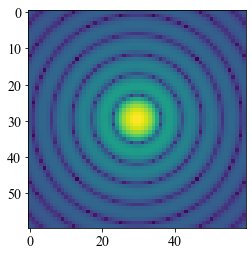

In [7]:
plt.imshow(psf.amplitude**0.25)

In [8]:
def objective(wavelength):
    psf,intermediate = osys.propagate_mono(wavelength*1e-6)   
    return (np.sum(psf.amplitude**2.))

objective(2.)

DeviceArray(0.9668657, dtype=float32)

In [9]:
thisgrad = grad(objective)
thisgrad(2.0)

DeviceArray(-0.01927833, dtype=float32)

In [10]:
%%time
print(thisgrad(2.0))

-0.019278333
CPU times: user 583 ms, sys: 195 ms, total: 777 ms
Wall time: 348 ms


## Now can we calculate a UV plane?

In [11]:
from morphine.matrixDFT import minimal_dft

In [12]:
arcsec2rad = np.pi/180./3600.
# experimental mathematics for the UV coords
arcsec2rad*psf.pixelscale * psf.shape[0] / 2.e-6*2*osys.planes[0].pupil_diam 

DeviceArray(21.816616, dtype=float32)

In [13]:
RADIUS = 2.0 # meters
WAVELENGTH = 2.0e-6 # meters
PIXSCALE = 0.02 # arcsec / pix
FOV = 4 # arcsec
NWAVES = 1.0
NPIX = 64


def calc_uv(wavefront,opsys,npix=128):
    nlamd = arcsec2rad*wavefront.pixelscale * wavefront.shape[0] / WAVELENGTH*2*opsys.planes[0].pupil_diam
    pupil = wavefront.intensity
    return minimal_dft(pupil, nlamd, npix)

In [14]:
uv = calc_uv(psf,osys)

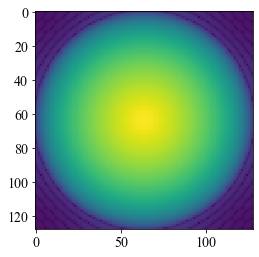

In [15]:
plt.imshow(np.abs(uv)**0.25)

## Non Zernike basis?

In [16]:
osys.planes[0].transmission

DeviceArray([[0., 0., 0., ..., 0., 0., 0.],
             [0., 0., 0., ..., 0., 0., 0.],
             [0., 0., 0., ..., 0., 0., 0.],
             ...,
             [0., 0., 0., ..., 0., 0., 0.],
             [0., 0., 0., ..., 0., 0., 0.],
             [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [17]:
class mywavefront(morphine.AnalyticOpticalElement):
    def __init__(self, wavelength, pupil, phasescreen, **kwargs):
        """ If your optic has adjustible parameters, then save them as attributes here """
        super().__init__()
        self.pupil = pupil
        self.wavelength = wavelength
        self.phasescreen = phasescreen

    def get_opd(self,wave):
        opd = self.phasescreen
        return opd

    def get_transmission(self, wave):
        transmission = self.pupil.get_transmission(wave)
        return transmission

    # behind the scenes morphine  will calculate:
    #    phasor = transmission = np.exp(1.j * 2 * np.pi / wave.wavelength * opd)


In [18]:
wfe = mywavefront(2.e-6,osys.planes[0],np.zeros_like(osys.planes[0].transmission))

In [19]:
pupil = osys.planes[0]


In [20]:
osys.planes[0].sample

<bound method AnalyticOpticalElement.sample of <morphine.optics.CircularAperture object at 0x10f11ac10>>

In [21]:
RADIUS = 2.0 # meters
WAVELENGTH = 2.0e-6 # meters
PIXSCALE = 0.02 # arcsec / pix
FOV = 4 # arcsec
NWAVES = 1.0
NPIX = 64

osys = morphine.OpticalSystem(npix=NPIX)
circular_aperture = morphine.CircularAperture(radius=RADIUS)
osys.add_pupil(circular_aperture)

wf = osys.input_wavefront()
wfe = mywavefront(WAVELENGTH,osys.planes[0],np.zeros_like(wf.coordinates()[0]))
osys.add_pupil(wfe)
osys.add_detector(pixelscale=PIXSCALE, fov_arcsec=FOV)

psf,intermediate = osys.propagate_mono(WAVELENGTH)

In [22]:
wf.amplitude.shape

(64, 64)

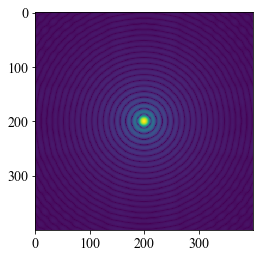

In [23]:
plt.imshow(psf.amplitude**0.5)

## Now let's try to autodiff this

In [24]:
def psf_from_phasescreen(phasescreen,wavel=WAVELENGTH):
    osys = morphine.OpticalSystem(npix=NPIX)
    circular_aperture = morphine.CircularAperture(radius=RADIUS,gray_pixel=False)
    osys.add_pupil(circular_aperture)

    wf = osys.input_wavefront()
    wfe = mywavefront(wavel,osys.planes[0],phasescreen)
    osys.add_pupil(wfe)
    osys.add_detector(pixelscale=PIXSCALE, fov_arcsec=FOV)

    psf,intermediate = osys.propagate_mono(wavel)
    return psf,osys

def end_to_end(phasescreen):
    psf, osys = psf_from_phasescreen(phasescreen)
    return calc_uv(psf,osys,npix=NPIX+1)

def uv_phase(phasescreen):
    return np.angle(end_to_end(phasescreen))

zero_phase = np.zeros_like(wf.coordinates()[0])

output = uv_phase(zero_phase)

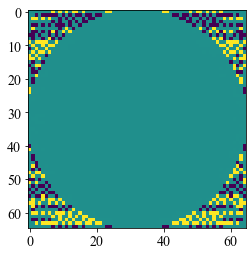

In [25]:
plt.imshow(output)

In [26]:
from jax import jacfwd, jacrev
from time import time as clock

In [27]:
%load_ext memory_profiler

In [28]:
# phasegrad = jacrev(uv_phase)

In [29]:
# %%memit 

# thisgrad = phasegrad(zero_phase)
# print(thisgrad.sum())


In [30]:
phasegrad = jacfwd(uv_phase)

In [31]:
# %%memit 

# thisgrad = phasegrad(zero_phase)
# print(thisgrad.sum())


In [32]:
%%time

thisgrad = phasegrad(zero_phase)
print(thisgrad.sum())


-20352.0
CPU times: user 1min 53s, sys: 1min 28s, total: 3min 22s
Wall time: 1min 28s


In [33]:
tic = clock()
print(thisgrad.sum())
toc = clock()
print(toc-tic)

-20352.0
0.020422935485839844


In [34]:
otf = end_to_end(zero_phase)

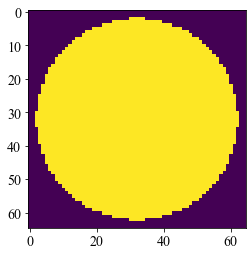

In [35]:
support = np.abs(otf) > 7.5e-5
plt.imshow(support)

In [36]:
print(np.sum(support>0))

2845


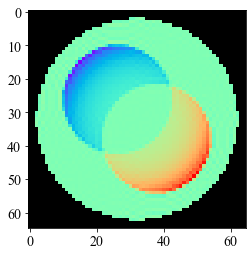

In [37]:
indices = 20

phases = onp.copy(thisgrad[:,:,indices,indices])
phases[support<1.] = np.nan
plt.imshow(phases,cmap=phasemap)


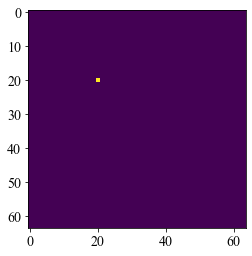

In [38]:
indices = 20
pupil_trans = osys.planes[0].transmission
phasescreen_test = onp.zeros_like(pupil_trans)
phasescreen_test[indices,indices] = 0.1

plt.imshow(phasescreen_test)

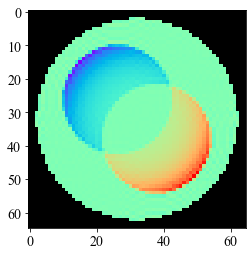

In [39]:
output = onp.array(uv_phase(phasescreen_test))
output[support<1.] = np.nan
plt.imshow(output,cmap=phasemap)


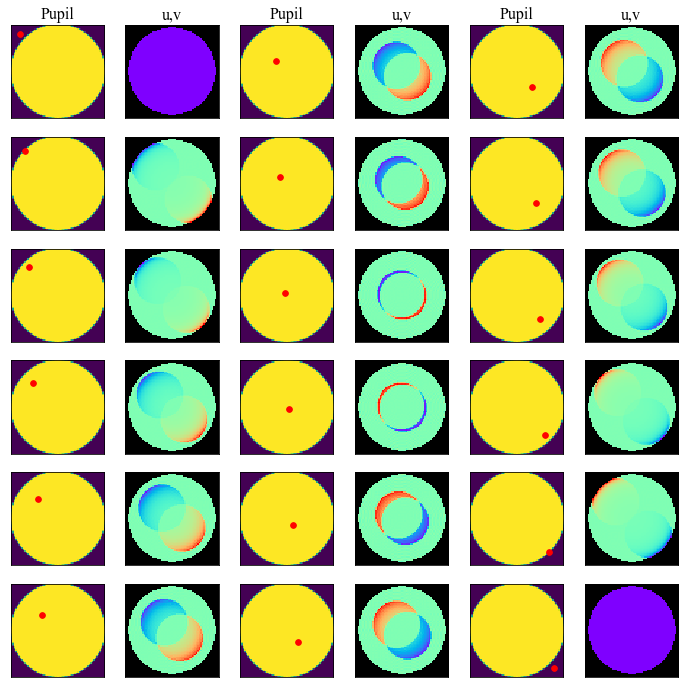

In [40]:
fig, ax = plt.subplots(6,6,figsize=(12, 12))
columns = 2
rows = 6
indices = 10
fs = 16

index_step = onp.floor((thisgrad.shape[3])/((3.*rows))).astype('int')

indices = index_step+3

for j in [0,2,4]:
    for i in range(rows):
#         print(indices)
#         ax[i,1+j].imshow(thisgrad[indices,indices,:,:],cmap=phasemap)
        phases = onp.copy(thisgrad[:,:,indices,indices])
        pupil_trans = osys.planes[0].transmission
        phases[support<1.] = np.nan
        ax[i,1+j].imshow(phases,cmap=phasemap)

        ax[i,1+j].set_xticks([])
        ax[i,1+j].set_yticks([])
        if i ==0:
            ax[i,1+j].set_title('u,v',fontsize=fs)
            ax[i,j].set_title('Pupil',fontsize=fs)

        ax[i,j].imshow(pupil_trans)
        ax[i,j].scatter(indices,indices,s=32,c='r')
        ax[i,j].set_xticks([])
        ax[i,j].set_yticks([])

        indices += index_step

# plt.savefig('jacobian.png',bbox_inches='tight')
plt.savefig('/Users/benjaminpope/code/morphine/paper/jacobian.pdf',bbox_inches='tight')

In [41]:
thisgrad.shape

(65, 65, 64, 64)

In [42]:
# transfer_martinache = thisgrad[:,:,support>0][pupil_trans==1,:].T
transfer= onp.array(thisgrad.reshape((NPIX+1)**2,NPIX**2))
transfer = transfer[support.ravel()==1.,:]
transfer = transfer[:,pupil_trans.ravel()==1.]

In [43]:
thisgrad[:,:,support>0].shape

(65, 65, 2845)

In [44]:
(support>0).sum(),(pupil_trans==1).sum()

(DeviceArray(2845, dtype=int32), DeviceArray(3080, dtype=int32))

In [45]:
print(transfer.shape)

(2845, 3080)


In [46]:
%%time
u1, s1, v1 = np.linalg.svd(transfer.T,full_matrices=False)

CPU times: user 271 ms, sys: 44.8 ms, total: 316 ms
Wall time: 82.4 ms


In [47]:
s1[6000]/s1[0]

DeviceArray(3.0321718e-09, dtype=float32)

In [48]:
np.sum((s1/s1[0])>5e-8)

DeviceArray(2834, dtype=int32)

In [49]:
from astropy.table import Table
broadband = Table.read('svd_broadband.txt',format='ascii')
corona = Table.read('svd_corona.txt',format='ascii')

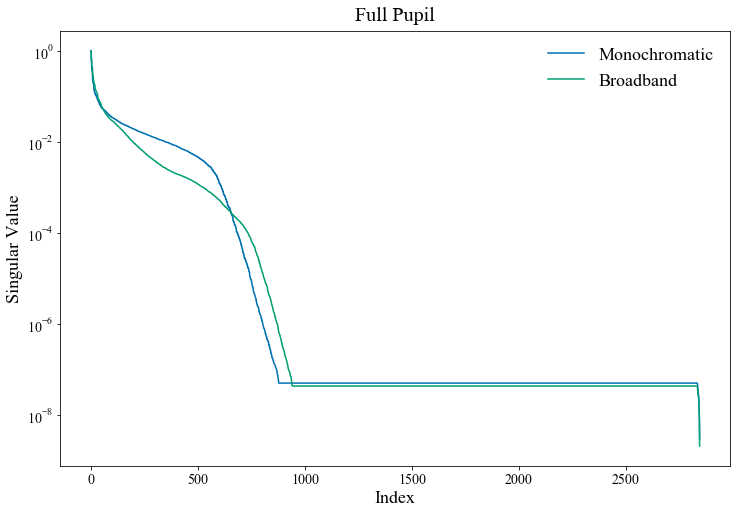

In [50]:
fig = plt.figure(figsize=(12.0,8.0))
plt.plot(s1/s1[0],label='Monochromatic')
plt.plot(broadband['S1'],label='Broadband')
# plt.plot(corona['S1'],label='Lyot Coronagraph')
plt.yscale('log')
plt.ylabel('Singular Value')
plt.xlabel('Index')
# plt.title('Kernel Phase Singular Value Spectrum',fontsize=24,y=1.01)
plt.title('Full Pupil',y=1.01,fontsize=20)
plt.legend(fontsize=18,frameon=False)
# plt.savefig('kerphi_singular.png',bbox_inches='tight')
plt.savefig('../paper/kerphi_singular.pdf',bbox_inches='tight')

In [51]:
np.median(s1/s1[0])

DeviceArray(5.1327646e-08, dtype=float32)

In [52]:
u1.shape, v1.shape

((3080, 2845), (2845, 2845))

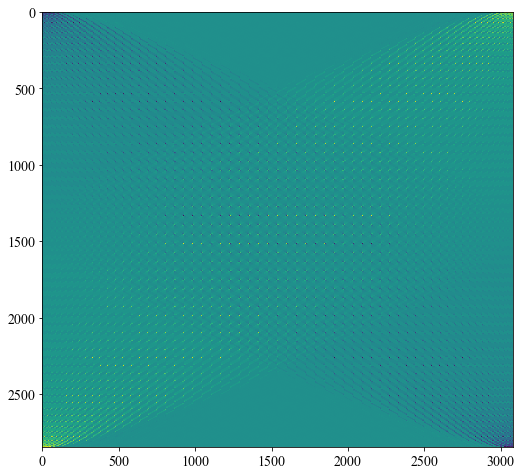

In [53]:
fig = plt.figure(figsize=(12.0,8.0))
plt.imshow((transfer),interpolation=None)

In [54]:
kernel = v1[1000:,:]
null = np.dot(kernel,transfer)

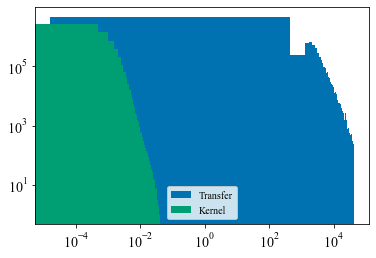

In [55]:
plt.hist(np.abs(transfer.ravel()),bins=100,label='Transfer');
plt.hist(np.abs(null.ravel()),bins=100,label='Kernel');

plt.xscale('log')
plt.yscale('log')
plt.legend()

### What do these kernel phase maps look like?

In [56]:
v1.shape

(2845, 2845)

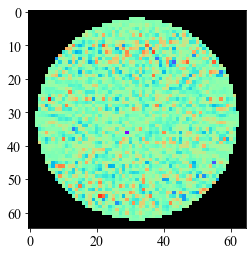

In [57]:
index = 1500

mode = 1.*onp.array(support)
mode[support>0] = v1[index,:]
mode[support<=0] = np.nan

plt.imshow(mode,cmap=phasemap)

In [58]:
u1.shape

(3080, 2845)

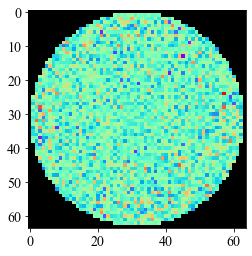

In [59]:
index = 1501

pupil_mode = 1.*onp.array(pupil_trans)
pupil_mode[pupil_trans==1.] = onp.array(u1[:,index])
pupil_mode[pupil_trans!=1.] = np.nan

plt.imshow(pupil_mode,cmap=phasemap)

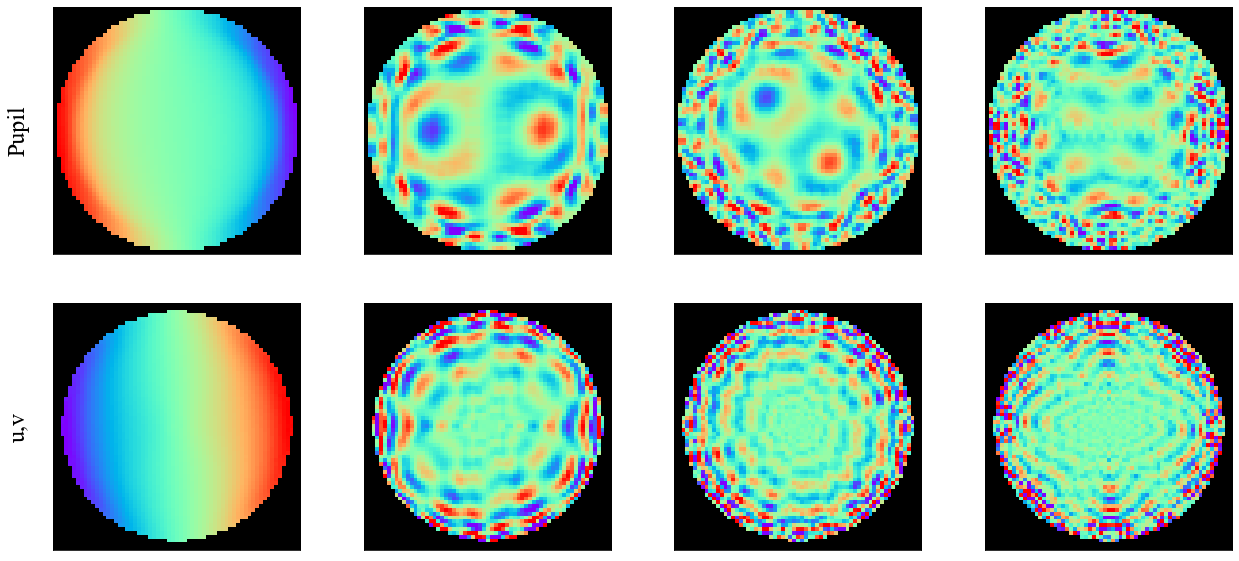

In [60]:
nsets = 4

fig, axes = plt.subplots(2,nsets,figsize=(8/3.*(nsets*2),10))

for ax in axes.ravel():
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set(aspect='equal')

axes[0,0].set_ylabel('Pupil',fontsize=24,labelpad=24)

axes[1,0].set_ylabel('u,v',fontsize=24,labelpad=24)


for j in range(nsets):
    mode = 1.*onp.array(support)
    mode[support>0] = v1[j*50,:]
    mode[support<=0] = np.nan
    if j == 0:
        vmin1, vmax1 = np.nanmin(mode),np.nanmax(mode)

    axes[1,j].imshow(mode,cmap=phasemap,vmin=vmin1,vmax=vmax1)  
    
    wavefront = onp.ones_like(pupil_trans)
    wavefront[pupil_trans==1.] *= u1[:,j*50]
    wavefront[pupil_trans!=1.] = np.nan
    
    if j == 0:
        vmin2, vmax2 = np.nanmin(wavefront),np.nanmax(wavefront)


    axes[0,j].imshow(wavefront,cmap=phasemap,vmin=vmin2,vmax=vmax2)
    current_cmap = mpl.cm.get_cmap()
    current_cmap.set_bad(color='k')

plt.savefig('/Users/benjaminpope/code/morphine/paper/nonsingular_modes_mono.pdf',bbox_inches='tight')

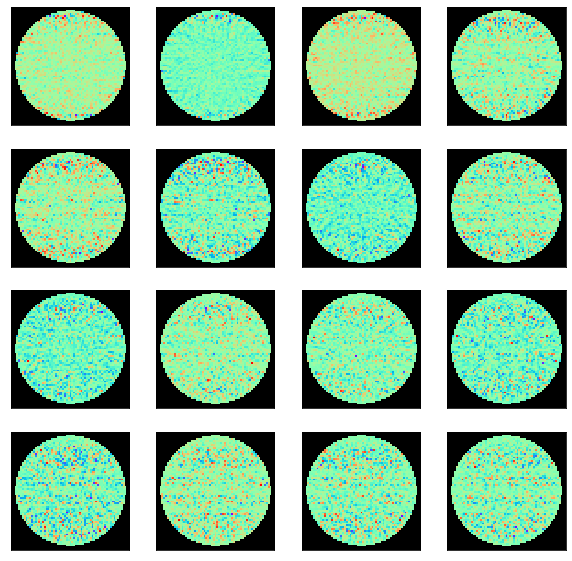

In [61]:
nsets = 4

fig, axes = plt.subplots(nsets,nsets,figsize=(10,10))

for ax in axes.ravel():
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set(aspect='equal')

for j, axis in enumerate(axes.ravel()):
    mode = 1.*onp.array(support)
    mode[support==1.] = v1[j*50+1000,:]
    mode[support<1.] = np.nan

    axis.imshow(mode,cmap=phasemap)  
    
    current_cmap = mpl.cm.get_cmap()
    current_cmap.set_bad(color='k')

plt.savefig('/Users/benjaminpope/code/morphine/paper/kernel_modes_mono.pdf',bbox_inches='tight')

### Now let's see what a planet looks like

In [62]:
help(morphine.zernike.zernike_basis)

Help on function zernike_basis in module morphine.zernike:

zernike_basis(nterms=15, npix=512, rho=None, theta=None, **kwargs)
    Return a cube of Zernike terms from 1 to N each as a 2D array
    showing the value at each point. (Regions outside the unit circle on which
    the Zernike is defined are initialized to zero.)
    
    Parameters
    -----------
    nterms : int, optional
        Number of Zernike terms to return, starting from piston.
        (e.g. ``nterms=1`` would return only the Zernike piston term.)
        Default is 15.
    npix : int
        Desired pixel diameter for circular pupil. Only used if `rho`
        and `theta` are not provided.
    rho, theta : array_like
        Image plane coordinates. `rho` should be 0 at the origin
        and 1.0 at the edge of the circular pupil. `theta` should be
        the angle in radians.
    
    Other parameters are passed through to `morphine.zernike.zernike`
    and are documented there.



In [63]:
NZ = 20

zernikes = morphine.zernike.zernike_basis(NZ,npix=NPIX,outside=0.0)



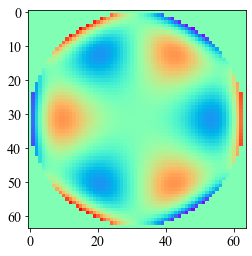

In [64]:
plt.imshow(zernikes[-3,:,:],cmap=phasemap)

In [65]:
coefficients_sequence = 10e-9*onp.random.randn(NZ)


# Classical Lyot FPM, spot radius ~ 4 lam/D
aberrated = morphine.OpticalSystem(npix=NPIX)
aberrated.add_pupil( morphine.CircularAperture(radius=RADIUS))
thinlens = morphine.ZernikeWFE(radius=RADIUS, coefficients=coefficients_sequence, cached_zernikes=zernikes)
aberrated.add_pupil(thinlens)
aberrated.add_detector( pixelscale=PIXSCALE, fov_arcsec=FOV )

blur,intermediate = aberrated.propagate_mono(WAVELENGTH,normalize='first')

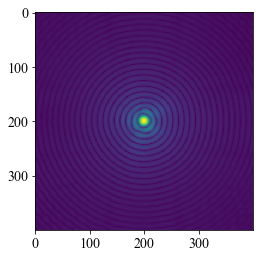

In [66]:
plt.imshow(blur.intensity**0.25)

252.11276 nm peak to peak


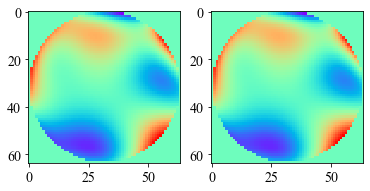

In [67]:
fig, axes = plt.subplots(1,2)
combined_zernikes = np.tensordot(coefficients_sequence,aberrated.planes[1].cached_zernikes,axes=(0,0))
print((combined_zernikes.max()-combined_zernikes.min())*1e9,'nm peak to peak')
axes[0].imshow(combined_zernikes,cmap=phasemap)
axes[1].imshow(aberrated.planes[1].get_opd(wf),cmap=phasemap)


In [68]:
offset = 0.5

aberrated.source_offset_r = offset
tilted, intertilt = aberrated.propagate_mono(WAVELENGTH,normalize='first')
aberrated.source_offset_r = 0

osys.source_offset_r = offset
tilted_pure, intertilt = osys.propagate_mono(WAVELENGTH,normalize='first')
osys.source_offset_r = 0

In [69]:
contrast = 5e-3
science = contrast*tilted.intensity+blur.intensity

In [70]:
def calc_uv_spec(intensity,wavefront,opsys,npix=128):
    nlamd = arcsec2rad*wavefront.pixelscale * wavefront.shape[0] / WAVELENGTH*2*opsys.planes[0].pupil_diam
    return minimal_dft(intensity, nlamd, npix)

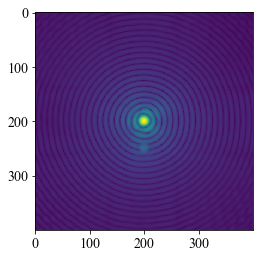

In [71]:
plt.imshow(science**0.2)

In [72]:
science_uv = calc_uv_spec(science,blur,aberrated,npix=NPIX+1)
planet_uv = calc_uv_spec((tilted_pure).intensity*contrast+psf.intensity,psf,osys,npix=NPIX+1)
no_planet_uv = calc_uv_spec(blur.intensity,blur,aberrated,npix=NPIX+1)
base_uv = calc_uv_spec(psf.intensity,blur,aberrated,npix=NPIX+1)


science_phase = np.angle(science_uv[support==1]).ravel()
planet_phase = np.angle(planet_uv[support==1]).ravel()
no_planet_phase = np.angle(no_planet_uv[support==1]).ravel()

Text(0.5, 1.0, 'Data')

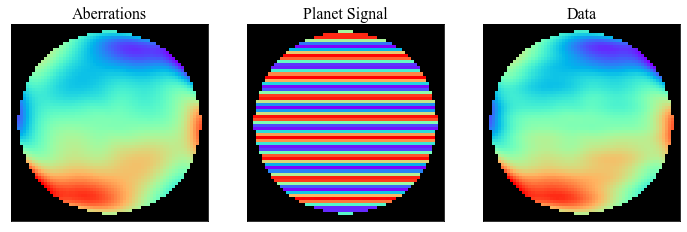

In [73]:
fig, axes = plt.subplots(1,3,figsize=(12.0,4.0))


for ax in axes.ravel():
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set(aspect='equal')

uvscale_noplanet = onp.copy(np.angle(no_planet_uv))
uvscale_noplanet[support!=1] = np.nan
axes[0].imshow(uvscale_noplanet,cmap=phasemap)
axes[0].set_title('Aberrations',fontsize=16)

uvscale_planet = onp.copy(np.angle(planet_uv))
uvscale_planet[support!=1] = np.nan
axes[1].imshow(uvscale_planet,cmap=phasemap)
axes[1].set_title('Planet Signal',fontsize=16)

uvscale_data = onp.copy(np.angle(science_uv))
uvscale_data[support!=1] = np.nan
axes[2].imshow(uvscale_data,cmap=phasemap)
axes[2].set_title('Data',fontsize=16)


In [74]:
kphi_sci = np.dot(kernel,science_phase)
kphi_planet = np.dot(kernel,planet_phase)
kphi_no_planet = np.dot(kernel,no_planet_phase)

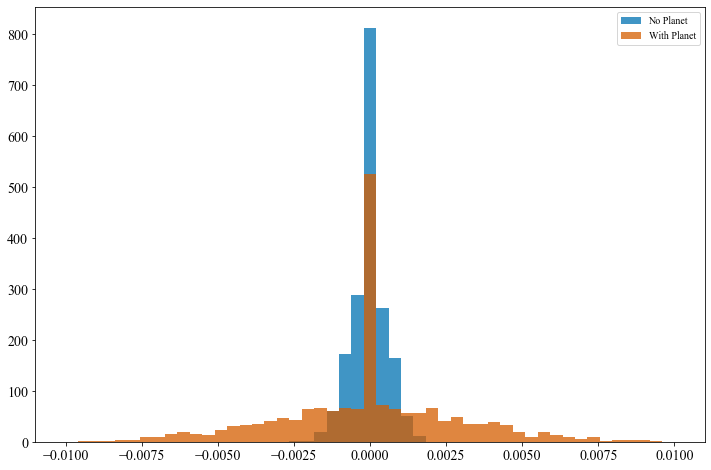

In [75]:
fig = plt.figure(figsize=(12.0,8.0))
bins=np.linspace(-0.01,0.01,50)
plt.hist(kphi_no_planet,bins=bins,label='No Planet',alpha=0.75);
plt.hist(kphi_sci,bins=bins,label='With Planet',alpha=0.75,color=colours[2]);

plt.legend()

# plt.xlim(-0.005,0.005)

Text(0.5, 1.0, 'Normal Phases')

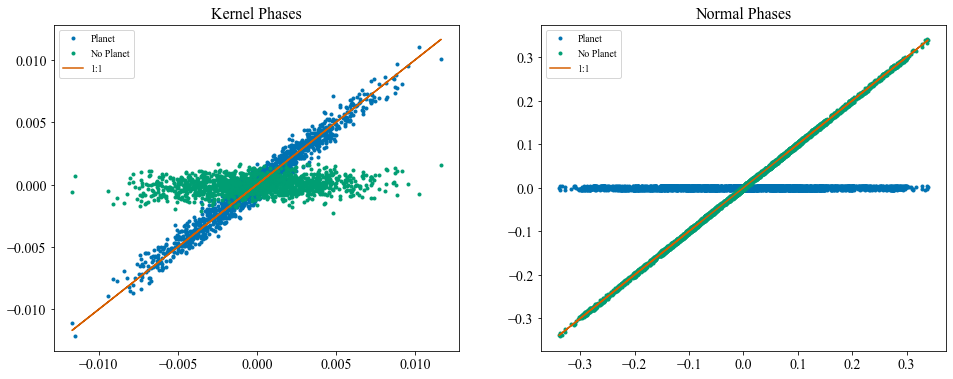

In [76]:
fig, axes = plt.subplots(1,2,figsize=(16.0,6.0))

axes[0].plot(kphi_sci,kphi_planet,'.',label='Planet')
axes[0].plot(kphi_sci,kphi_no_planet,'.',label='No Planet')
axes[0].plot(kphi_sci,kphi_sci,'-',label='1:1')

axes[0].legend()
axes[0].set_title('Kernel Phases',fontsize=16)

axes[1].plot(science_phase,planet_phase,'.',label='Planet')
axes[1].plot(science_phase,no_planet_phase,'.',label='No Planet')
axes[1].plot(science_phase,science_phase,'-',label='1:1')

axes[1].legend()
axes[1].set_title('Normal Phases',fontsize=16)
